# SPI Calculation
Calculate SPI using the SPEI python package (https://github.com/martinvonk/spei).
Needed data is the precipitation and evapotranspiration.

In [2]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import scipy.stats as scs
import spei as si
from datetime import datetime
import matplotlib.pyplot as plt


Define the date range. Timerange must be at least 306 days.
Otherwise the calculation will throw an error but I do not know how the spei package actually works.

In [3]:
def get_range_days(start_date, end_date):
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    return (end_dt - start_dt).days

def check_date_range(start_date, end_date):
    days = get_range_days(start_date, end_date)
    return (days, days >= 306)

In [4]:
start_date = "2019-01-01"
end_date = "2023-10-31"

In [7]:
# Check if data range has more than 306 days
date_range_valid = check_date_range(start_date, end_date)
if not date_range_valid[1]:
    raise Exception(f"Date range must be bigger than 306 days but is {date_range_valid[0]} days.")

date_range_valid

(1764, True)

## Meteorological data
The OpenMeteo Weather API will let you call 10.000 requests per day for free.
We need the precipitation and evapotranspiration values to calculate the drought index SPEI.

This script was taken from the offical API documentation (https://open-meteo.com/en/docs/historical-weather-api/) which generate a Python script for the user.

You can choose between hourly and daily values for a specific date range.

In [8]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [9]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 53.595204,
    "longitude": 10.019017,
    "start_date": start_date,
    "end_date": end_date,
    "daily": ["precipitation_sum"],
    "timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [10]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 53.60280990600586°E 10.0°N
Elevation 23.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [11]:
# Transform values into a numpy array
daily = response.Daily()
daily_precipitation_sum = daily.Variables(0).ValuesAsNumpy()

In [12]:
# Create a pandas date time index for the subsequent linking of the meterological values to the date 
end_date_pd = pd.to_datetime(start_date) + pd.DateOffset(days=len(daily_precipitation_sum) - 1)
date_range = pd.date_range(start=start_date, end=end_date_pd)
date_range

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', length=1765, freq='D')

In [13]:
# Create a pandas Series with dates as the index
prec_series = pd.Series(daily_precipitation_sum, index=date_range)
prec_series

2019-01-01     1.000000
2019-01-02     0.000000
2019-01-03     0.000000
2019-01-04     0.000000
2019-01-05     1.400000
                ...    
2023-10-27     3.300000
2023-10-28     2.600000
2023-10-29    11.800001
2023-10-30     2.100000
2023-10-31     8.400001
Freq: D, Length: 1765, dtype: float32

In [14]:
prec_series

2019-01-01     1.000000
2019-01-02     0.000000
2019-01-03     0.000000
2019-01-04     0.000000
2019-01-05     1.400000
                ...    
2023-10-27     3.300000
2023-10-28     2.600000
2023-10-29    11.800001
2023-10-30     2.100000
2023-10-31     8.400001
Freq: D, Length: 1765, dtype: float32

You will need at least n days of data to calculate the SPEI for a specific day because this is the value for the rolling window. Means we calculate the sum for each n days window and then drop the NaN values. 

In [15]:
days = 30 # days

pe_roll = prec_series.rolling(f"{days}D", min_periods=days)
pe_roll_sum = pe_roll.sum().dropna()
pe_roll_sum

2019-01-30     60.099998
2019-01-31     59.699998
2019-02-01     59.899998
2019-02-02     61.499998
2019-02-03     61.499998
                 ...    
2023-10-27    142.000010
2023-10-28    144.600010
2023-10-29    152.500011
2023-10-30    154.600011
2023-10-31    156.900012
Freq: D, Length: 1736, dtype: float64

In [16]:
# Check if enough data rows are given
if not pe_roll_sum.size >= 306:
    raise Exception(f"Date range must be bigger than 306 days but is {pe_roll_sum.size} days.")

pe_roll_sum.size

1736

Distribution: Gamma

In [17]:
spi_gamma = si.spi(pe_roll_sum, dist=scs.gamma)
spi_gamma

2019-01-30   -0.556339
2019-01-31   -0.574249
2019-02-01   -0.535024
2019-02-02   -0.459697
2019-02-03   -0.459697
                ...   
2023-10-27    1.424892
2023-10-28    1.470438
2023-10-29    1.605109
2023-10-30    1.640019
2023-10-31    1.677849
Freq: D, Length: 1736, dtype: float64

Distribution: Pearson3

In [18]:
spi_pearson = si.spi(pe_roll_sum, dist=scs.pearson3)
spi_pearson

2019-01-30   -0.556337
2019-01-31   -0.574247
2019-02-01   -0.535025
2019-02-02   -0.459698
2019-02-03   -0.459698
                ...   
2023-10-27    1.424892
2023-10-28    1.470439
2023-10-29    1.605110
2023-10-30    1.640020
2023-10-31    1.677851
Freq: D, Length: 1736, dtype: float64

## Visualize indices
For better understanding of the values we need to visualize the SPEI values.
The indices should be interpreted as such:

| Range of Values   | Regime            |
|-------------------|-------------------|
| 2 < SI <= MAX     | Extremely Wet     |
| 1.5 < SI <= 2.0   | Very Wet          |
| 1.0 < SI <=1.5    | Moderately Wet    |
| -1.0 < SI <= 1.0  | Normal Conditions |
| -1.5 < SI <= -1.0 | Moderately Dry    |
| -2.0 < SI <= -1.5 | Very Dry          |
| MIN <= SI <= -2.0 | Extremely Dry     |

In [21]:
# Sample data for illustration (replace this with your actual data)
data = [0.5, 1.5, -1.2, -0.5, 2.0, -0.8, 1.2, -1.5, 0.7]
spei_series = pd.Series(data)

# Define the regimes and corresponding ranges
regimes = {
    'Extremely Wet': (2, float('inf')),
    'Very Wet': (1.5, 2.0),
    'Moderately Wet': (1.0, 1.5),
    'Normal Conditions': (-1.0, 1.0),
    'Moderately Dry': (-1.5, -1.0),
    'Very Dry': (-2.0, -1.5),
    'Extremely Dry': (float('-inf'), -2.0)
}

# Ensure bins are in ascending order
bins = sorted([regime[0] for regime in regimes.values()] + [float('inf')])

# Categorize values into regimes
spei_ranges = pd.cut(spei_series, bins=bins, labels=regimes.keys())

# Calculate the percentage for each regime
percentage_by_regime = spei_ranges.value_counts(normalize=True) * 100


Distribution Gamma -> Drought Category Distribution

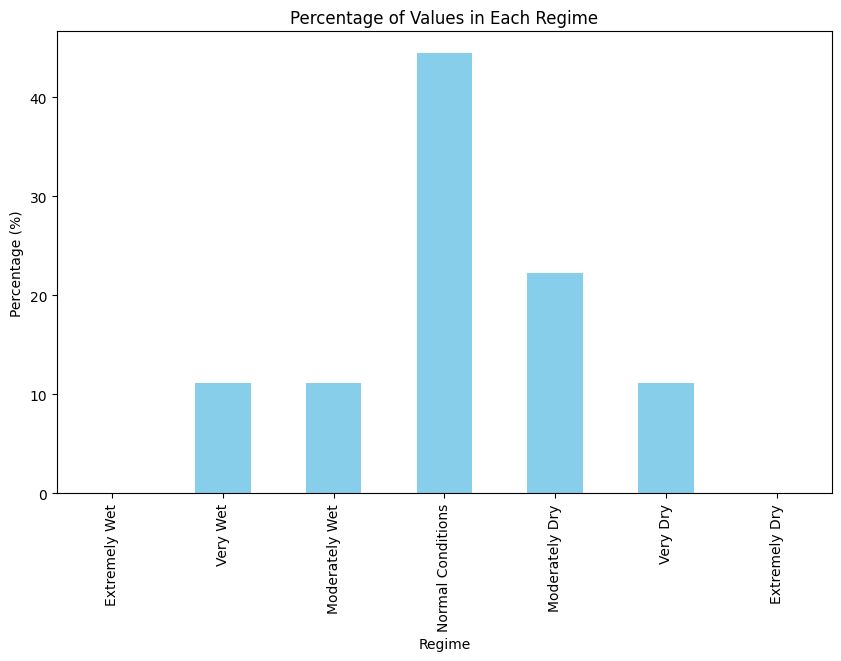

In [22]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
percentage_by_regime.sort_index().plot(kind='bar', color='skyblue', ax=ax)

# Add labels and title
plt.title('Percentage of Values in Each Regime')
plt.xlabel('Regime')
plt.ylabel('Percentage (%)')

# Show the plot
plt.show()

Distribution Pearson -> Drought Category Distribution

In [23]:
# Sample data for illustration (replace this with your actual data)
data = [0.5, 1.5, -1.2, -0.5, 2.0, -0.8, 1.2, -1.5, 0.7]
spei_series = pd.Series(data)

# Define the regimes and corresponding ranges
regimes = {
    'Extremely Wet': (2, float('inf')),
    'Very Wet': (1.5, 2.0),
    'Moderately Wet': (1.0, 1.5),
    'Normal Conditions': (-1.0, 1.0),
    'Moderately Dry': (-1.5, -1.0),
    'Very Dry': (-2.0, -1.5),
    'Extremely Dry': (float('-inf'), -2.0)
}

# Ensure bins are in ascending order
bins = sorted([regime[0] for regime in regimes.values()] + [float('inf')])

# Categorize values into regimes
spei_ranges = pd.cut(spei_series, bins=bins, labels=regimes.keys())

# Calculate the percentage for each regime
percentage_by_regime = spei_ranges.value_counts(normalize=True) * 100


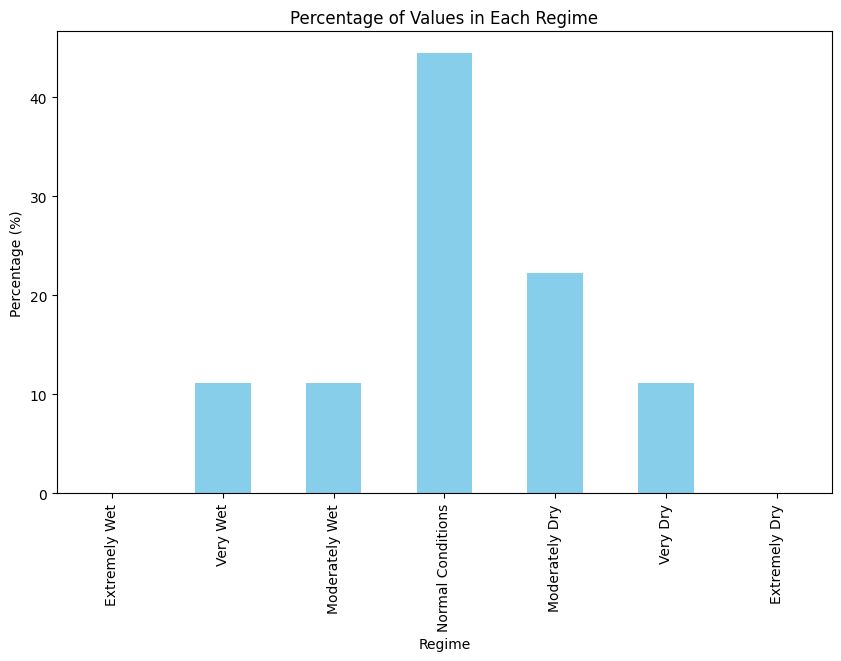

In [24]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
percentage_by_regime.sort_index().plot(kind='bar', color='skyblue', ax=ax)

# Add labels and title
plt.title('Percentage of Values in Each Regime')
plt.xlabel('Regime')
plt.ylabel('Percentage (%)')

# Show the plot
plt.show()

SPI Plotting: Gamma

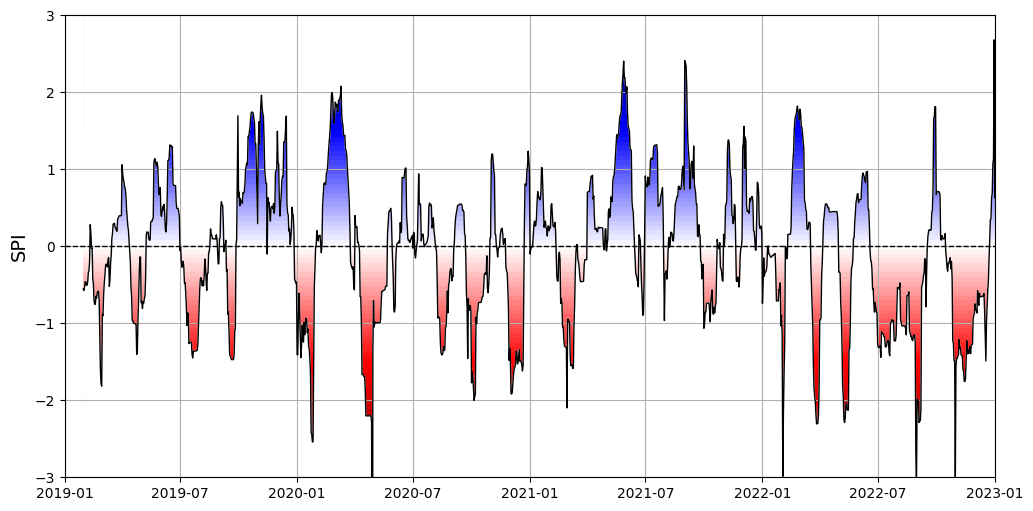

In [29]:

# Create a subplot
days, ax = plt.subplots(figsize=(12, 6))

# Plot SPEI on the subplot
si.plot.si(spi_gamma, ax=ax)

# Set x-axis limits
# ax.set_xlim(pd.to_datetime(["1980", "2016"]))
# ax.set_xlim(pd.to_datetime(["2019", "2023"]))
ax.set_xlim(pd.to_datetime([str(start_date[:4]), str(end_date[:4])]))

# Add grid to the subplot
ax.grid()

# Set y-axis label
ax.set_ylabel("SPI", fontsize=14)

plt.show()

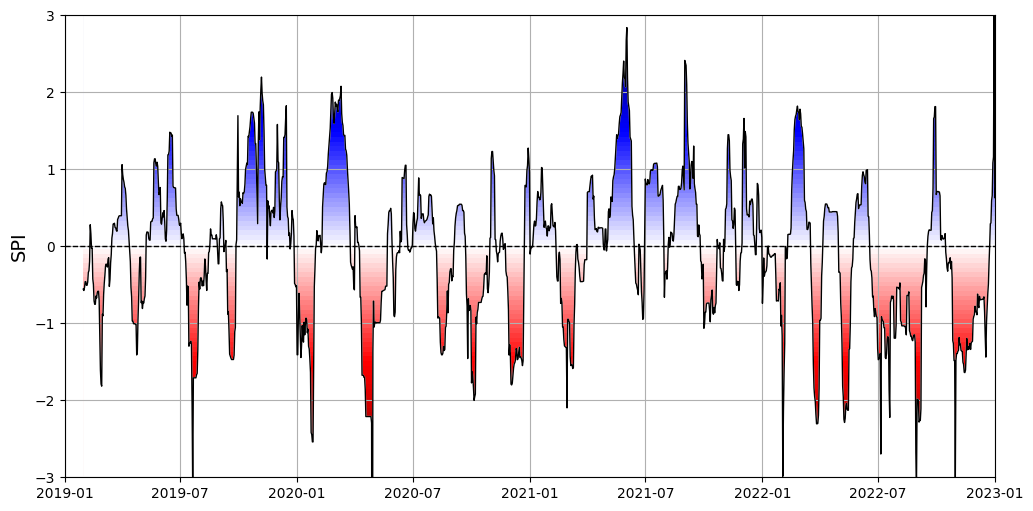

In [30]:

# Create a subplot
days, ax = plt.subplots(figsize=(12, 6))

# Plot SPEI on the subplot
si.plot.si(spi_pearson, ax=ax)

# Set x-axis limits
# ax.set_xlim(pd.to_datetime(["1980", "2016"]))
# ax.set_xlim(pd.to_datetime(["2019", "2023"]))
ax.set_xlim(pd.to_datetime([str(start_date[:4]), str(end_date[:4])]))

# Add grid to the subplot
ax.grid()

# Set y-axis label
ax.set_ylabel("SPI", fontsize=14)

plt.show()